In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pygam import LogisticGAM
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp
from scipy import stats

### Question 2

In [151]:
marketing_data = pd.read_csv("marketing.csv")
marketing_data_encoded = pd.get_dummies(columns=["job", "marital", "education","default", "housing","loan"],
                                        data=marketing_data)
marketing_data_encoded['y'] = np.where(marketing_data_encoded['y'] == 'yes',1,0)
X = marketing_data_encoded.drop(axis=1,columns=['y'])
y = marketing_data_encoded[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
base_rate = sum(y_train.y==1)/len(y_train)
print("Base rate of success in the training data is", round(base_rate,3))
lmfit = LogisticRegression(C=100000).fit(X_train, y_train)
yhat_lm = lmfit.predict(X_test)
miss_rate = np.mean(np.array(y_test)!=yhat_lm)
print("Misclassification rate of logistic regression is", round(miss_rate,6))

Base rate of success in the training data is 0.118
Misclassification rate of logistic regression is 0.115436


In [ ]:
GAMfit = LogisticGAM().gridsearch(np.array(X_train), np.array(y_train), lam = np.logspace(-2, 3, 30))

In [152]:
yhat_gam = GAMfit.predict(np.array(X_test))
print("Misclassification rate for Logistic GAM fit is", round(np.mean(yhat_gam!=np.array(y_test)),3))

Misclassification rate for Logistic GAM fit is 0.121


#### Part (a)

In [15]:
classifier = RandomForestClassifier(n_estimators=500,oob_score=True)
treefit = classifier.fit(X_train,y_train)

C:\Users\shuva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### (i)

In [39]:
yhat_tree = treefit.predict(X_test)
print("Misclassification rate for Random Forest fit is", round(np.mean(yhat_tree!=np.array(y_test)),3))

Misclassification rate for Random Forest fit is 0.168


Misclassification rate of the Random Forest classifier is 0.168. Based on the misclassification rate, random forest fit is worse than the logistic regression and logistic GAM fit as these two classifier had lower misclassification rate. Even the base rate is lower than this misclassification rate.

In [153]:
print("OOB error for Random Forest fit is", 1-round(treefit.oob_score_,3))

OOB error for Random Forest fit is 0.129


The Out of Bag error, which is similar to cross validation error for the random forest fit is 0.129 which is close to the misclassification rate in test set.

#### (ii)

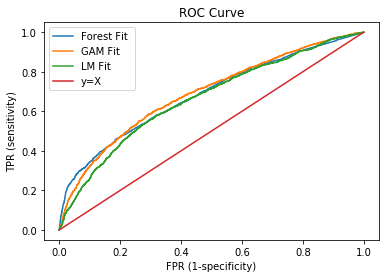

In [55]:
fpr_gam,tpr_gam,_ = roc_curve(y_test.y,GAMfit.predict_proba(np.array(X_test)))
fpr_tree,tpr_tree,_ = roc_curve(y_test.y,treefit.predict_proba(np.array(X_test))[:,1])
fpr_lm,tpr_lm,_ = roc_curve(y_test.y,lmfit.predict_proba(np.array(X_test))[:,1])
plt.xlabel("FPR (1-specificity)")
plt.ylabel("TPR (sensitivity)")
plt.title("ROC Curve")
plt.plot(fpr_tree,tpr_tree,label="Forest Fit ")
plt.plot(fpr_gam,tpr_gam,label="GAM Fit")
plt.plot(fpr_lm,tpr_lm,label="LM Fit")
plt.plot(np.linspace(0,1), np.linspace(0,1),label="y=X")
plt.gca().legend()
plt.show()

Above shows the ROC curves overlapped on each other. The curves are very similar between FPR values between [0.5, 1]. At small values of FPR, between [0.0, 0.2] random forest fit has some better TPR than other fits, and between [0.2, 0.6], the logistic GAM has better TPR values compared to other fits.

In [59]:
auc_lm = roc_auc_score(y_test.y,lmfit.predict_proba(np.array(X_test))[:,1])
print("AUC for Logistic Regression is ", round(auc_lm,3))
auc_gam = roc_auc_score(y_test.y,GAMfit.predict_proba(np.array(X_test)))
print("AUC for Logistic GAM is ", round(auc_gam,3))
auc_forest = roc_auc_score(y_test.y,treefit.predict_proba(np.array(X_test))[:,1])
print("AUC for Random Forest is ", round(auc_forest,3))


AUC for Logistic Regression is  0.664
AUC for Logistic GAM is  0.688
AUC for Random Forest is  0.682


Above shows the AUC of the three classifiers. The Random forest classifier has improved upon logistic regression classifier, but still not the best among the three as the logistic GAM has slightly higher AUC value.

#### (iii)

In [64]:
def calc_success_fraction(probability,y_test,):
    #Partitions the array into two sub-arrays like quick sort. Left of the index are all less than the index
    #Picks 1000 highest log-probability points
    high_prob_indices = np.argpartition(probability, len(probability)-1000)[-1000:]
    success_count_frac = sum(y_test.iloc[high_prob_indices].y == 1)/1000
    print("Among set of top 1000 clients, success fraction is", round(success_count_frac,3))
    return()
gam_test_prob = GAMfit.predict_proba(np.array(X_test))
rf_test_prob = treefit.predict_proba(np.array(X_test))[:,1]
lm_test_prob = lmfit.predict_proba(np.array(X_test))[:,1]
print("Random Forest Fit :")
calc_success_fraction(rf_test_prob,y_test)
print("Logistic GAM Fit :")
calc_success_fraction(gam_test_prob,y_test)
print("Logistic Regression Fit :")
calc_success_fraction(lm_test_prob,y_test)


Random Forest Fit :
Among set of top 1000 clients, success fraction is 0.432
Logistic GAM Fit :
Among set of top 1000 clients, success fraction is 0.346
Logistic Regression Fit :
Among set of top 1000 clients, success fraction is 0.279


()

From above, we can see that the random forest classifier does better job in classifying top 1000 client success rate than other classifiers. It has a success rate of 0.432 among the top 1000 clients while Logistic GAM has 0.346 and Logistic Regression has 0.279.

#### Part (b)

In [65]:
classifier2 = RandomForestClassifier(n_estimators=500,oob_score=True,min_samples_leaf=10)
treefit2 = classifier2.fit(X_train,y_train)

C:\Users\shuva\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### (i)

In [67]:
yhat_tree = treefit2.predict(X_test)
print("Misclassification rate for this Random Forest fit is", round(np.mean(yhat_tree!=np.array(y_test)),3))

Misclassification rate for this Random Forest fit is 0.117


Misclassification rate of this new Random Forest classifier is 0.117. Based on the misclassification rate, this new random forest fit is much better than previous fit and logistic GAM fit as these two classifier had higher misclassification rate. This misclassification rate beats the base rate but logistic regression has a better misclassification rate,

In [155]:
print("OOB error for this Random Forest fit is", 1-round(treefit2.oob_score_,3))

OOB error for this Random Forest fit is 0.118


The Out of Bag error, which is similar to cross validation error for this new random forest fit is 0.118 which is slightly better than the OOB error of previous random forest fit and close to test misclassification rate.

#### (ii)

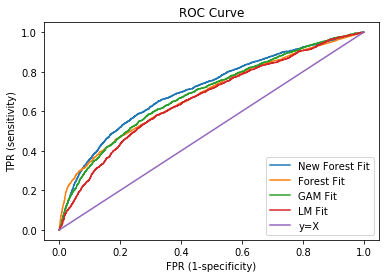

In [70]:
fpr_gam,tpr_gam,_ = roc_curve(y_test.y,GAMfit.predict_proba(np.array(X_test)))
fpr_tree,tpr_tree,_ = roc_curve(y_test.y,treefit.predict_proba(np.array(X_test))[:,1])
fpr_tree2,tpr_tree2,_ = roc_curve(y_test.y,treefit2.predict_proba(np.array(X_test))[:,1])
fpr_lm,tpr_lm,_ = roc_curve(y_test.y,lmfit.predict_proba(np.array(X_test))[:,1])
plt.xlabel("FPR (1-specificity)")
plt.ylabel("TPR (sensitivity)")
plt.title("ROC Curve")
plt.plot(fpr_tree2,tpr_tree2,label="New Forest Fit")
plt.plot(fpr_tree,tpr_tree,label="Forest Fit")
plt.plot(fpr_gam,tpr_gam,label="GAM Fit")
plt.plot(fpr_lm,tpr_lm,label="LM Fit")
plt.plot(np.linspace(0,1), np.linspace(0,1),label="y=X")
plt.gca().legend()
plt.show()

This new random forest fit does a much better job of classification based on the ROC curve as it encompasses all the other ROC curves from other classifier. We expect an improved AUC value for this classifier

In [75]:
auc_lm = roc_auc_score(y_test.y,lmfit.predict_proba(np.array(X_test))[:,1])
print("AUC for Logistic Regression is ", round(auc_lm,3))
auc_gam = roc_auc_score(y_test.y,GAMfit.predict_proba(np.array(X_test)))
print("AUC for Logistic GAM is ", round(auc_gam,3))
auc_forest = roc_auc_score(y_test.y,treefit.predict_proba(np.array(X_test))[:,1])
print("AUC for Random Forest is ", round(auc_forest,3))
auc_forest2 = roc_auc_score(y_test.y,treefit2.predict_proba(np.array(X_test))[:,1])
print("AUC for New Random Forest is ", round(auc_forest2,3))

AUC for Logistic Regression is  0.664
AUC for Logistic GAM is  0.688
AUC for Random Forest is  0.682
AUC for New Random Forest is  0.71


As expected, the AUC value for new random forest is better than all the other classifier and has a value of 0.71 which by far is the best result.

#### (iii)

In [72]:
gam_test_prob = GAMfit.predict_proba(np.array(X_test))
rf_test_prob = treefit.predict_proba(np.array(X_test))[:,1]
rf2_test_prob = treefit2.predict_proba(np.array(X_test))[:,1]
lm_test_prob = lmfit.predict_proba(np.array(X_test))[:,1]
print("New Random Forest Fit :")
calc_success_fraction(rf2_test_prob,y_test)
print("Random Forest Fit :")
calc_success_fraction(rf_test_prob,y_test)
print("Logistic GAM Fit :")
calc_success_fraction(gam_test_prob,y_test)
print("Logistic Regression Fit :")
calc_success_fraction(lm_test_prob,y_test)

New Random Forest Fit :
Among set of top 1000 clients, success fraction is 0.383
Random Forest Fit :
Among set of top 1000 clients, success fraction is 0.432
Logistic GAM Fit :
Among set of top 1000 clients, success fraction is 0.346
Logistic Regression Fit :
Among set of top 1000 clients, success fraction is 0.279


()

Looks like the new random forest classifier beats the logistic GAM and logistic regression classifier in top 1000 success rate, but does a poor job compared to the previous random forest classifier.

#### Part (c)

In [157]:
classifier3 = RandomForestClassifier(n_estimators=500,oob_score=True,min_samples_leaf=10,class_weight='balanced')
treefit3 = classifier3.fit(X_train,y_train)

In [158]:
yhat_tree = treefit3.predict(X_test)
print("Misclassification rate for this Random Forest fit is", round(np.mean(yhat_tree!=np.array(y_test)),3))

Misclassification rate for this Random Forest fit is 0.296


Misclassification rate for the balanced Random Forest fit is much worse than all the classifiers thus far. It has unusually high misclassification rate

In [76]:
auc_lm = roc_auc_score(y_test.y,lmfit.predict_proba(np.array(X_test))[:,1])
print("AUC for Logistic Regression is ", round(auc_lm,3))
auc_gam = roc_auc_score(y_test.y,GAMfit.predict_proba(np.array(X_test)))
print("AUC for Logistic GAM is ", round(auc_gam,3))
auc_forest = roc_auc_score(y_test.y,treefit.predict_proba(np.array(X_test))[:,1])
print("AUC for Random Forest is ", round(auc_forest,3))
auc_forest2 = roc_auc_score(y_test.y,treefit2.predict_proba(np.array(X_test))[:,1])
print("AUC for Modified Random Forest is ", round(auc_forest2,3))
auc_forest3 = roc_auc_score(y_test.y,treefit3.predict_proba(np.array(X_test))[:,1])
print("AUC for Balanced Random Forest is ", round(auc_forest3,3))


AUC for Logistic Regression is  0.664
AUC for Logistic GAM is  0.688
AUC for Random Forest is  0.682
AUC for Modifier Random Forest is  0.71
AUC for Balanced Random Forest is  0.711


Addition of weights to the random forest hasn't improved the AUC much. Only a slight increase from previous version of the modified random forest. Still beats rest of the classifiers.

In [79]:
gam_test_prob = GAMfit.predict_proba(np.array(X_test))
rf_test_prob = treefit.predict_proba(np.array(X_test))[:,1]
rf2_test_prob = treefit2.predict_proba(np.array(X_test))[:,1]
rf3_test_prob = treefit3.predict_proba(np.array(X_test))[:,1]
lm_test_prob = lmfit.predict_proba(np.array(X_test))[:,1]
print("Balanced Random Forest Fit :")
calc_success_fraction(rf3_test_prob,y_test)
print("Modified Random Forest Fit :")
calc_success_fraction(rf2_test_prob,y_test)
print("Random Forest Fit :")
calc_success_fraction(rf_test_prob,y_test)
print("Logistic GAM Fit :")
calc_success_fraction(gam_test_prob,y_test)
print("Logistic Regression Fit :")
calc_success_fraction(lm_test_prob,y_test)

Balanced Random Forest Fit :
Among set of top 1000 clients, success fraction is 0.385
Modified Random Forest Fit :
Among set of top 1000 clients, success fraction is 0.383
Random Forest Fit :
Among set of top 1000 clients, success fraction is 0.432
Logistic GAM Fit :
Among set of top 1000 clients, success fraction is 0.346
Logistic Regression Fit :
Among set of top 1000 clients, success fraction is 0.279


()

From above it looks like the balanced Random Forest does a better job compared to the unbalanced random forest fit in the top 1000 success rate. Still the first random forest does the best job compared to the other classifiers.

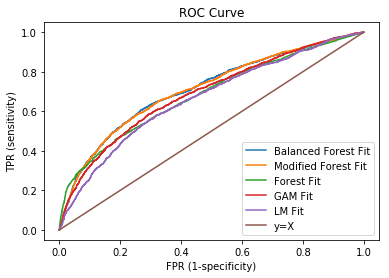

In [77]:
fpr_gam,tpr_gam,_ = roc_curve(y_test.y,GAMfit.predict_proba(np.array(X_test)))
fpr_tree,tpr_tree,_ = roc_curve(y_test.y,treefit.predict_proba(np.array(X_test))[:,1])
fpr_tree2,tpr_tree2,_ = roc_curve(y_test.y,treefit2.predict_proba(np.array(X_test))[:,1])
fpr_tree3,tpr_tree3,_ = roc_curve(y_test.y,treefit3.predict_proba(np.array(X_test))[:,1])
fpr_lm,tpr_lm,_ = roc_curve(y_test.y,lmfit.predict_proba(np.array(X_test))[:,1])
plt.xlabel("FPR (1-specificity)")
plt.ylabel("TPR (sensitivity)")
plt.title("ROC Curve")
plt.plot(fpr_tree3,tpr_tree3,label="Balanced Forest Fit")
plt.plot(fpr_tree2,tpr_tree2,label="Modified Forest Fit")
plt.plot(fpr_tree,tpr_tree,label="Forest Fit")
plt.plot(fpr_gam,tpr_gam,label="GAM Fit")
plt.plot(fpr_lm,tpr_lm,label="LM Fit")
plt.plot(np.linspace(0,1), np.linspace(0,1),label="y=X")
plt.gca().legend()
plt.show()

From above ROC plot, we can see that the balanced random forest almost co-incides with the unbalanced fit, but does a slightly better job in terms of AUC and top 1000 success rate.

When we fit a random forest or any classifier with different weights to the data points, we are essentially using an asymmetric loss function to minimize and solve for a classifier. Whereas misclassification rate gives equal weight to each correct/incorrect classification and thus is a symmetric loss based measure. 

Because of the weights added, the overall loss became asymmetric and thus the fit performs significantly worse on a symmetric loss based measure such as misclassification rate.

### Question 3

#### Part (a)

Below shows the variable importance plot. Two of the most important variables in the classifier is balance and age, with combined importance more than 55%

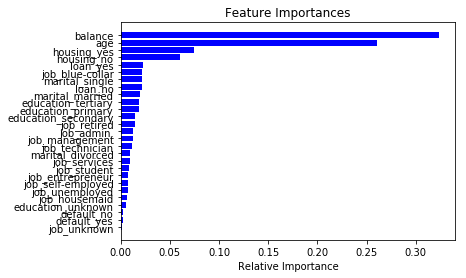

In [80]:
features = X_train.columns
importances = treefit3.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Part (b)

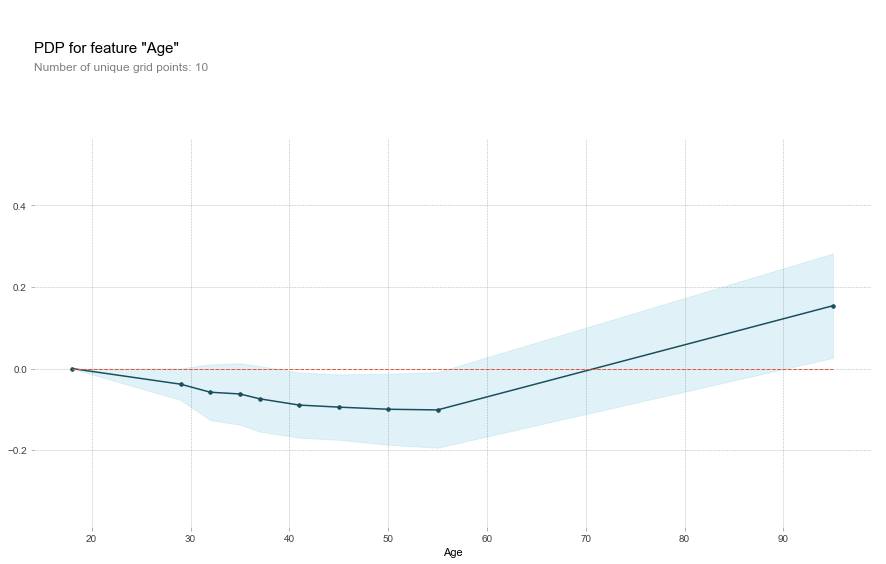

In [83]:
pdp_obj = pdp.pdp_isolate(model=treefit3, dataset=X_train,
model_features=X_train.columns, feature='age')
fig, axes = pdp.pdp_plot(pdp_obj, 'Age')

Above plot shows the partial dependence plot of the classifier with the feature 'age'. The trend in the predictions with the feature 'age' is similar to the logistic GAM classifier where the frequency of success goes down with increase in age over a certain range of [20,50] and again starts going up again with increase in age over the range [50,90]

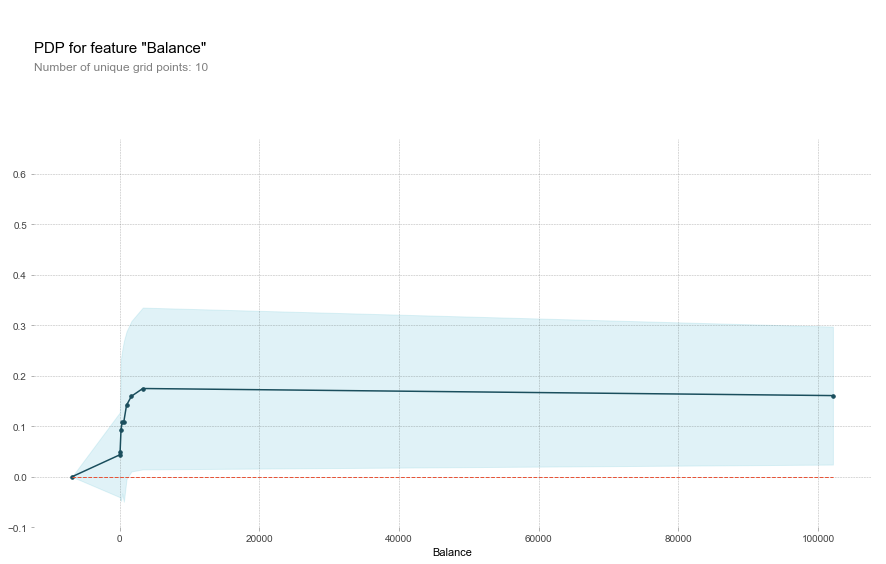

In [84]:
pdp_obj = pdp.pdp_isolate(model=treefit3, dataset=X_train,
model_features=X_train.columns, feature='balance')
fig, axes = pdp.pdp_plot(pdp_obj, 'Balance')

Above plot shows the partial dependence plot of the classifier with the feature 'balance'. The trend in the predictions with the feature 'balance' is slightly different compared to the logistic GAM classifier. With increase in balance, the success rate sharply goes up over the range of [0,5000], and stays almost the same beyond that range.

### Question4

#### Part (a)

In [30]:
def get_data(n):
    p=1000
    X = stats.norm().rvs(n*p).reshape((n,p))
    Y = stats.norm().rvs(n)
    return(X,Y)

#Generate some data
n = 100
X,y = get_data(n)

In [31]:
correlations = np.apply_along_axis(stats.pearsonr,0,X,y)

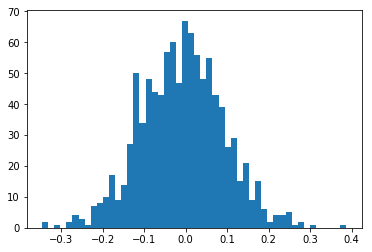

In [32]:
plot = plt.hist(correlations[0,:],bins=50)

#### Part (b)

In [33]:
X_good = X[:,correlations[0,:]>0.2]

#### Part (c)

In [34]:
X_train = X_good[:80,:]
y_train = y[:80]
X_test = X_good[80:,:]
y_test = y[80:]

In [35]:
lassofit = LassoCV(cv=5).fit(X_train, y_train)

In [36]:
CV_MSE = np.mean(lassofit.mse_path_,axis=1)
print("Cross Validated MSE for the Lasso Fit is", round(np.min(CV_MSE),4))
y_hat = lassofit.predict(X_test)
test_MSE = np.mean((y_hat-y_test)**2)
print("Test MSE for the Lasso Fit is", round(test_MSE,4))

Cross Validated MSE for the Lasso Fit is 0.5079
Test MSE for the Lasso Fit is 0.7315


#### Part (d)

In [37]:
X_new,y_new = get_data(n)
X_new_good = X_new[:,correlations[0,:]>0.2]
y_hat_new = lassofit.predict(X_new_good)
test_MSE_new = np.mean((y_hat_new-y_new)**2)
print("Test MSE for the Lasso Fit is", round(test_MSE_new,4))

Test MSE for the Lasso Fit is 1.5196


The new test MSE on freshly generated data is significantly higher than the test MSE in part (c). This can be explained because we calculated the pairwise correlation on initial dataset and filtered the columns with correlation less than 0.2. The test data points also contains columns with correlation more than 0.2 because we performed the filtration before the train-test split.

When we generated new data set, those columns gave large MSE, simply because the samples are actually independent and new samples will show no trend or relation and thus the predicted values will no explain the actual output resulting into high test MSE.

The solution to such incorrect validation result is to perform the train test split before filtering and not allow the filter bias to be present in the test data. For example if we modify the above process with below, then the test MSE is similar between fresh samples and split test set.

In [39]:
#Generate some data
n = 100
X,y = get_data(n)
X_train = X[:80,:]
y_train = y[:80]
X_test = X[80:,:]
y_test = y[80:]
correlations = np.apply_along_axis(stats.pearsonr,0,X_train,y_train)
X_good = X_train[:,correlations[0,:]>0.2]
lassofit = LassoCV(cv=5).fit(X_good, y_train)
CV_MSE = np.mean(lassofit.mse_path_,axis=1)
print("Cross Validated MSE for the new Lasso Fit is", round(np.min(CV_MSE),4))
y_hat = lassofit.predict(X_test[:,correlations[0,:]>0.2])
test_MSE = np.mean((y_hat-y_test)**2)
print("Test MSE for the new Lasso Fit is", round(test_MSE,4))
X_new,y_new = get_data(n)
X_new_good = X_new[:,correlations[0,:]>0.2]
y_hat_new = lassofit.predict(X_new_good)
test_MSE_new = np.mean((y_hat_new-y_new)**2)
print("Test MSE for the Lasso Fit is", round(test_MSE_new,4))

Cross Validated MSE for the new Lasso Fit is 0.431
Test MSE for the new Lasso Fit is 1.0199
Test MSE for the Lasso Fit is 1.1297


We can see that the test MSE between freshly generated data and split test data to be very close because of the correct way of splitting the data into train test before making any filtration.